# Pitch & Roll prediction model

In [389]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import json
import pickle
import multiprocessing
import platform
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [390]:
print(torch.__version__)
print(pl.__version__)

1.10.2
1.5.10


In [391]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

Num GPUs Available:  0
device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Constants

In [392]:
N_EPISODES = 540
FRAMES_PER_EPISODE = 400
TRAIN_FOLDER = "3dmodel/test_4_episode_"
SEQUENCE_LENGTH = 3

TRAIN_SIZE = 0.8
NUM_EPOCHS = 8
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

CUDA = device.type == 'cuda'

# Load data from episodes

In [393]:
# view first episode 
filename = "../3dmodel/test_4_episode_1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468
...,...,...
395,-0.204481,1.503337
396,1.074743,10.724272
397,13.373594,1.542949
398,11.193637,-0.848632


In [394]:
# load all data
pr = []
episodes = []
for ep in range(1, N_EPISODES+1):
    filename = "../3dmodel/test_4_episode_"+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        pr.append(labels[i])
        episodes.append(labels[i]+[ep, i])

In [395]:
p_r_df = pd.DataFrame(episodes)
p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df

,pitch,roll,episode,position_within_episode
0,15.915869,2.358416,1,0
1,14.295925,1.700391,1,1
2,6.213590,1.611325,1,2
3,1.235337,6.175461,1,3
4,1.341678,3.695468,1,4
...,...,...,...,...
215995,0.428497,-0.663964,540,395
215996,0.485498,-1.376229,540,396
215997,-0.658033,-1.328761,540,397
215998,-1.322262,-1.650465,540,398


In [396]:
df2 = p_r_df.copy()
df2["pr"] = list(zip(p_r_df["pitch"].round(2), p_r_df["roll"].round(2)))
df2.drop(columns=["pitch","roll"], axis=0, inplace=True)
df2 = df2[["pr","episode","position_within_episode"]]
rows = df2.groupby('episode')['pr'].apply(list)
df_stack = pd.DataFrame(rows)
df_stack = df_stack.reset_index()
df_stack

,episode,pr
0,1,"[(15.92, 2.36), (14.3, 1.7), (6.21, 1.61), (1...."
1,2,"[(15.98, 2.27), (9.86, 1.36), (6.11, 1.56), (1..."
2,3,"[(15.96, 2.07), (6.18, 0.12), (6.08, 1.68), (1..."
3,4,"[(7.7, 1.58), (8.48, 0.06), (3.16, 0.86), (1.0..."
4,5,"[(7.81, 1.49), (7.87, 0.18), (3.13, 0.91), (0...."
...,...,...
535,536,"[(27.03, -7.86), (19.12, -5.18), (12.65, -3.41..."
536,537,"[(18.02, -5.29), (18.95, -5.79), (10.58, -2.69..."
537,538,"[(21.82, -6.14), (14.1, -3.58), (9.7, -2.57), ..."
538,539,"[(21.23, -6.12), (16.44, -4.69), (10.11, -2.68..."


In [397]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

In [398]:
# Function to normalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [399]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df

,pitch,roll,episode,position_within_episode
0,0.176843,0.026205,1,0
1,0.158844,0.018893,1,1
2,0.069040,0.017904,1,2
3,0.013726,0.068616,1,3
4,0.014908,0.041061,1,4
...,...,...,...,...
215995,0.004761,-0.007377,540,395
215996,0.005394,-0.015291,540,396
215997,-0.007311,-0.014764,540,397
215998,-0.014692,-0.018338,540,398


# Create sequences with target value

In [400]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, target_columns, sequence_length, feature_columns = ["pitch", "roll"], episode_length = FRAMES_PER_EPISODE, n_episodes = N_EPISODES):
    sequences= []
    # get indice(s) for target column(s)
    target_index = [input_data.columns.get_loc(c) for c in target_columns if c in input_data]

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-SEQUENCE_LENGTH):
            
            i = l+(n*episode_length)

            sequence = input_data.iloc[i:i+sequence_length][feature_columns]

            target_position = i + sequence_length
            target = input_data.iloc[[target_position], target_index].values.flatten()

            sequences.append((sequence, target))

    return sequences

In [401]:
target = ["pitch","roll"]
all_sequences = create_sequences(p_r_df, target, SEQUENCE_LENGTH)

  0%|          | 0/540 [00:00<?, ?it/s]

In [402]:
len(all_sequences),all_sequences[0][0].shape, all_sequences[0][1].shape 

(214380, (3, 2), (2,))

In [403]:
all_sequences[0][1]

array([0.01372597, 0.06861623])

In [404]:
index = 0
print("Sequence for target value: ", all_sequences[index][1])
pd.concat([all_sequences[index][0].head(2),all_sequences[index][0].tail(2)])

Sequence for target value:  [0.01372597 0.06861623]


,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
1,0.158844,0.018893
2,0.069040,0.017904


In [405]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print(len(train_indices), len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
171504 42876
[167621, 29184, 6556, 194393, 72097, 64196, 58513, 36579, 193061, 26868]
[3, 4, 131077, 131078, 7, 8, 131081, 131083, 131087, 21]


In [406]:
# drop temporary episode and position_within_episode columns in all sequences
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/171504 [00:00<?, ?it/s]

  0%|          | 0/42876 [00:00<?, ?it/s]

True
171504 (3, 2) (2,)
42876 (3, 2) (2,)


## Pytorch Dataset

In [407]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            labels = torch.Tensor(labels)
        )

In [408]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [409]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [410]:
data_module_train_dataloader = data_module.train_dataloader()
data_module_train_dataloader.dataset.__getitem__(0)["sequence"].shape, data_module_train_dataloader.dataset.__getitem__(0)["labels"]

(torch.Size([3, 2]), tensor([-0.0219, -0.0071]))

In [411]:
# batch size 64, 2 in- and out features
for batch in data_module_train_dataloader:
    print(batch["sequence"].shape)
    print(batch["labels"].shape)
    break

torch.Size([64, 3, 2])
torch.Size([64, 2])


In [412]:
# turn sequence list into Dataset object
train_dataset = PRDataset(train_sequences)

In [413]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["labels"].shape)
    print(item["labels"])
    break

torch.Size([3, 2])
torch.Size([2])
tensor([-0.0219, -0.0071])


## LSTM Model

In [414]:
class PRPredictionModel(nn.Module):

    # INPUT LAYER (2 features) --> LSTM 128 hidden --> LSTM 128 hidden --> Linear --> OUTPUT (2 features)
    def __init__(self, in_features, out_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.2
        )

        self.regressor = nn.Linear(in_features=n_hidden, out_features=out_features)

    def forward(self, x):
        # call flatten_parameters function to aggregate all the weight 
        # tensors into continuous space of GPU memory
        self.lstm.flatten_parameters()
    
        output, (hidden_state, cell_state) = self.lstm(x)
        out = hidden_state[-1]

        return self.regressor(out)

# Training

In [415]:
model = PRPredictionModel(2,2)

if CUDA:
    model.cuda()

x_train = 0
y_train = 0

for batch in data_module_train_dataloader:
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 3, 2]) torch.Size([64, 2])


In [416]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses_epoch = []
losses_all_batches = []

n_epochs = 100

for epoch in tqdm(range(n_epochs)):

    i = 0
    losses_batch = []

    for batch in data_module_train_dataloader:
        x_train = batch["sequence"]
        y_train = batch["labels"]

        if CUDA: 
            x_train = batch["sequence"].cuda()
            y_train = batch["labels"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)
        if CUDA: 
            y_pred = y_pred.cuda()
        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        losses_batch.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses_all_batches.append((epoch,losses_batch))

    # loss per epoch is average over all batches
    sum = 0
    for l in losses_batch:
        sum += l
    
    mean = sum/len(losses_batch)
    losses_epoch.append(mean)
    print(f"EPOCH {epoch} training loss: {mean}")

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.002506856806576252
EPOCH 1 training loss: 0.002309816423803568
EPOCH 2 training loss: 0.0022841913159936666
EPOCH 3 training loss: 0.0022598435170948505
EPOCH 4 training loss: 0.0022428492084145546
EPOCH 5 training loss: 0.0022306113969534636
EPOCH 6 training loss: 0.0022189009469002485
EPOCH 7 training loss: 0.002209058031439781
EPOCH 8 training loss: 0.0022022384218871593
EPOCH 9 training loss: 0.002197651658207178
EPOCH 10 training loss: 0.0021919740829616785
EPOCH 11 training loss: 0.0021867111790925264
EPOCH 12 training loss: 0.0021796701475977898
EPOCH 13 training loss: 0.0021741478703916073
EPOCH 14 training loss: 0.002169060055166483
EPOCH 15 training loss: 0.0021628832910209894
EPOCH 16 training loss: 0.002156261121854186
EPOCH 17 training loss: 0.0021527756471186876
EPOCH 18 training loss: 0.0021444917656481266
EPOCH 19 training loss: 0.002140686148777604
EPOCH 20 training loss: 0.0021356851793825626
EPOCH 21 training loss: 0.002129180124029517
EPOCH 

# Training results

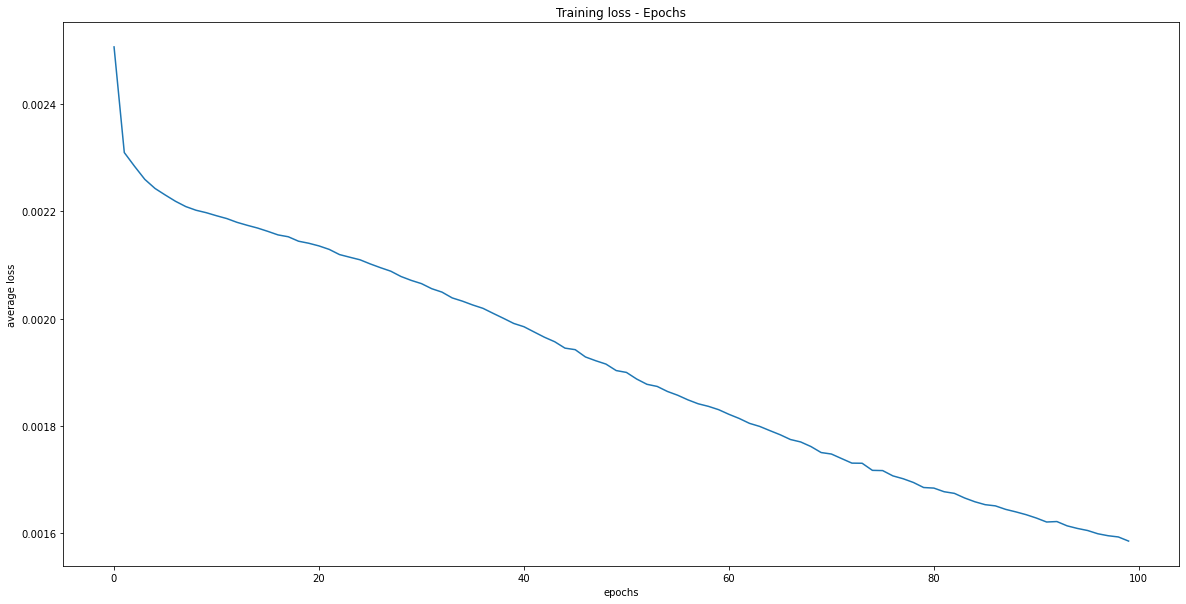

In [417]:
plt.figure(figsize=(20, 10))
plt.plot(range(n_epochs), losses_epoch)
plt.title("Training loss - Epochs")
plt.xlabel("epochs")
plt.ylabel("average loss")
plt.show()

In [418]:
modelname = 'model_states/PR_LSTM_'+str(SEQUENCE_LENGTH)
torch.save(model.state_dict(), modelname)

In [419]:
loaded_model = PRPredictionModel(in_features=2, out_features=2)
loaded_model.load_state_dict(torch.load(modelname))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

PRPredictionModel(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Linear(in_features=128, out_features=2, bias=True)
)

# Testing

In [420]:
x_test = 0
y_test = 0

for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 3, 2]) torch.Size([1, 2])


In [421]:
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)
    print(f'prediction:\t{y_pred}\nreal:\t\t{y_test}')
    print("loss:", loss.item())

prediction:	tensor([[-0.0022,  0.0368]], device='cuda:0')
real:		tensor([[-0.0488,  0.0097]], device='cuda:0')
loss: 0.0014518874231725931


In [422]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        output = loaded_model(x_test)
        predictions.append(output.detach().to('cpu').numpy().flatten())
        labels.append(y_test.detach().to('cpu').numpy().flatten())

  0%|          | 0/42876 [00:00<?, ?it/s]

In [423]:
# Predictions[0] = np array object
# Predictions[0][0] = pitch value
# Predictions[0][1] = roll value

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

### Pitch results

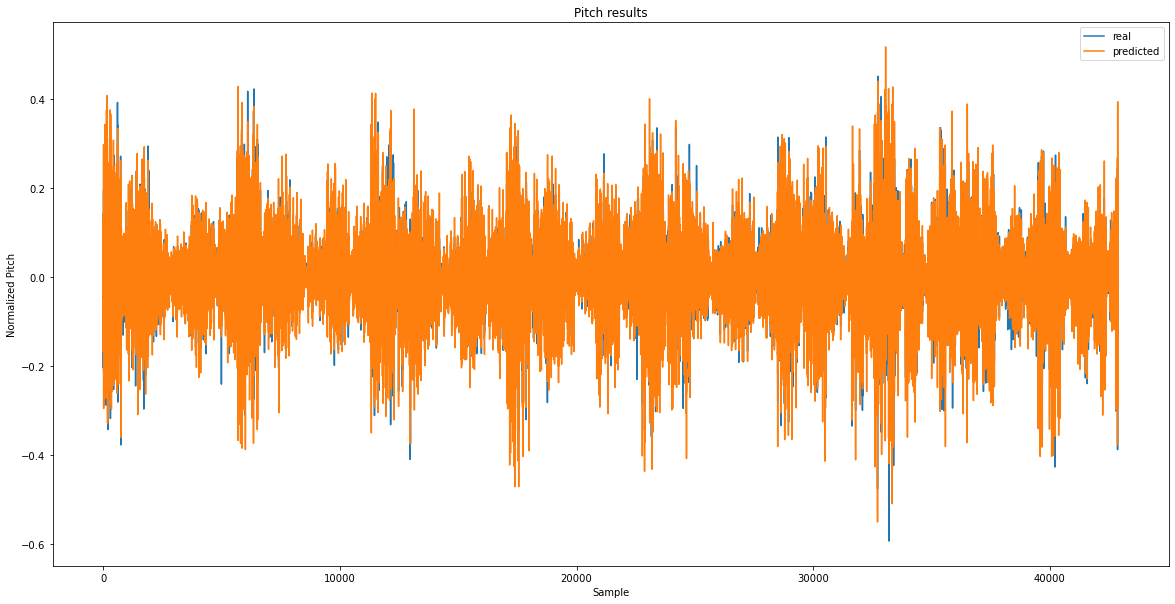

In [424]:
plt.figure(figsize=(20, 10))
plt.plot(pitch_predictions, label="real")
plt.plot(pitch_label, label="predicted")
plt.title("Pitch results")
plt.xlabel("Sample")
plt.ylabel("Normalized Pitch")
plt.legend()

In [425]:
n = len(pitch_predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (pitch_label[i]-pitch_predictions[i])**2
    loss0 += (pitch_label[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print("   RMSE denorm:", denorm_pr(rmse))
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print("   RMSE 0 denorm:", denorm_pr(rmse0))
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.0023414378731940774
   RMSE: 0.04838840639237954
   RMSE denorm: 4.354956575314162
Zero prediction
   MSE 0: 0.005360464071201772
   RMSE 0: 0.07321519016708057
   RMSE 0 denorm: 6.589367115037248
Improvement on zero prediction:
   MSE delta%: 228.94 %
   RMSE delta%: 151.31 %


### Roll results

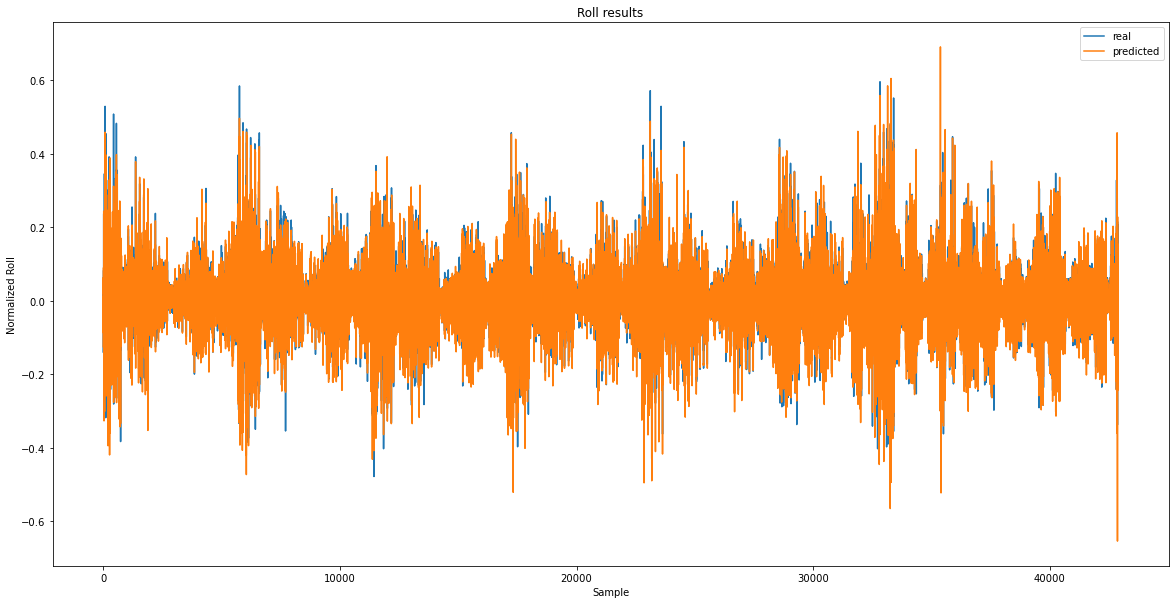

In [426]:
plt.figure(figsize=(20, 10))
plt.plot(roll_predictions, label="real")
plt.plot(roll_label, label="predicted")
plt.title("Roll results")
plt.xlabel("Sample")
plt.ylabel("Normalized Roll")
plt.legend()

In [427]:
n = len(roll_predictions)
loss = 0
loss0 = 0

for i in range(n):
    loss += (roll_label[i]-roll_predictions[i])**2
    loss0 += (roll_label[i]-0)**2

mse = loss/n
rmse = math.sqrt(loss/n)
mse0 = loss0/n
rmse0 = math.sqrt(loss0/n)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print("   RMSE denorm:", denorm_pr(rmse))
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print("   RMSE 0 denorm:", denorm_pr(rmse0))
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.0014488642568414635
   RMSE: 0.038063949569657946
   RMSE denorm: 3.425755461269219
Zero prediction
   MSE 0: 0.006113523214884462
   RMSE 0: 0.07818902234255434
   RMSE 0 denorm: 7.0370120108298835
Improvement on zero prediction:
   MSE delta%: 421.95 %
   RMSE delta%: 205.41 %
